In [1]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '../data/raw'
processed_dir = '../data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

Synthetic dataset with two columns created and saved to ../data/raw/outliers_homework.csv


In [4]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)  

outliers_daily_return = detect_outliers_iqr(df['daily_return'])
outliers_daily_return_2 = detect_outliers_iqr(df['daily_return_2'])
print("Outliers in 'daily_return':")
print(outliers_daily_return.value_counts())
print("\nOutliers in 'daily_return_2':")
print(outliers_daily_return_2.value_counts())

def detect_outliers_zscore(series, threshold=3):
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    return z_scores.abs() > threshold

outliers_zscore_daily_return = detect_outliers_zscore(df['daily_return'])
outliers_zscore_daily_return_2 = detect_outliers_zscore(df['daily_return_2']) 
#print the above as summary
print("\nZ-score Outliers in 'daily_return':")
print(outliers_zscore_daily_return.value_counts())
print("\nZ-score Outliers in 'daily_return_2':")
print(outliers_zscore_daily_return_2.value_counts())

def winsorize_series(series, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = series.quantile(lower_percentile)
    upper_bound = series.quantile(upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)

winsorized_daily_return = winsorize_series(df['daily_return'])
winsorized_daily_return_2 = winsorize_series(df['daily_return_2'])

#print the above as summary
print("\nWinsorized 'daily_return':")
print(winsorized_daily_return.describe())
print("\nWinsorized 'daily_return_2':")
print(winsorized_daily_return_2.describe())

Outliers in 'daily_return':
daily_return
False    106
True       9
Name: count, dtype: int64

Outliers in 'daily_return_2':
daily_return_2
False    108
True       7
Name: count, dtype: int64

Z-score Outliers in 'daily_return':
daily_return
False    110
True       5
Name: count, dtype: int64

Z-score Outliers in 'daily_return_2':
daily_return_2
False    110
True       5
Name: count, dtype: int64

Winsorized 'daily_return':
count    115.000000
mean      -0.000251
std        0.010623
min       -0.020590
25%       -0.008525
50%       -0.000187
75%        0.006368
max        0.020797
Name: daily_return, dtype: float64

Winsorized 'daily_return_2':
count    115.000000
mean      -0.000181
std        0.008312
min       -0.015440
25%       -0.005645
50%       -0.000174
75%        0.004679
max        0.016599
Name: daily_return_2, dtype: float64


In [10]:
# Create a DataFrame of summary stats
def summary_stats(df_subset, label):
    return pd.Series({
        'label': label,
        'mean_return': df_subset['daily_return'].mean(),
        'median_return': df_subset['daily_return'].median(),
        'std_return': df_subset['daily_return'].std(),
        'mean_return_2': df_subset['daily_return_2'].mean(),
        'median_return_2': df_subset['daily_return_2'].median(),
        'std_return_2': df_subset['daily_return_2'].std()
    })

# Filter data
df_iqr_filtered = df[~(outliers_daily_return | outliers_daily_return_2)]

# Create summaries
original_stats = summary_stats(df, 'Original')
iqr_filtered_stats = summary_stats(df_iqr_filtered, 'IQR Filtered')
winsorized_stats = summary_stats(
    pd.DataFrame({
        'daily_return': winsorized_daily_return,
        'daily_return_2': winsorized_daily_return_2
    }),
    'Winsorized'
)

# Combine into a summary table
summary_table = pd.DataFrame([original_stats, iqr_filtered_stats, winsorized_stats])
print(summary_table)


          label  mean_return  median_return  std_return  mean_return_2  \
0      Original    -0.001434      -0.000187    0.040579      -0.000668   
1  IQR Filtered    -0.000039      -0.000100    0.009443      -0.000072   
2    Winsorized    -0.000251      -0.000187    0.010623      -0.000181   

   median_return_2  std_return_2  
0        -0.000174      0.025068  
1        -0.000173      0.007353  
2        -0.000174      0.008312  


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

def regression_results(X, y):
    model = LinearRegression().fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    return {
        'coef': model.coef_[0],
        'intercept': model.intercept_,
        'r2': r2_score(y, y_pred),
        'mae': mean_absolute_error(y, y_pred)
    }

# Prepare regression sets
reg_original = regression_results(df['daily_return'].values, df['daily_return_2'].values)
reg_iqr_filtered = regression_results(df_iqr_filtered['daily_return'].values, df_iqr_filtered['daily_return_2'].values)
reg_winsorized = regression_results(winsorized_daily_return.values, winsorized_daily_return_2.values)

# Combine into DataFrame
regression_df = pd.DataFrame([
    {'label': 'Original', **reg_original},
    {'label': 'IQR Filtered', **reg_iqr_filtered},
    {'label': 'Winsorized', **reg_winsorized}
])
print(regression_df)


          label      coef  intercept        r2       mae
0      Original  0.605869   0.000201  0.961859  0.003951
1  IQR Filtered  0.589679  -0.000049  0.573566  0.003851
2    Winsorized  0.649705  -0.000017  0.689444  0.003741


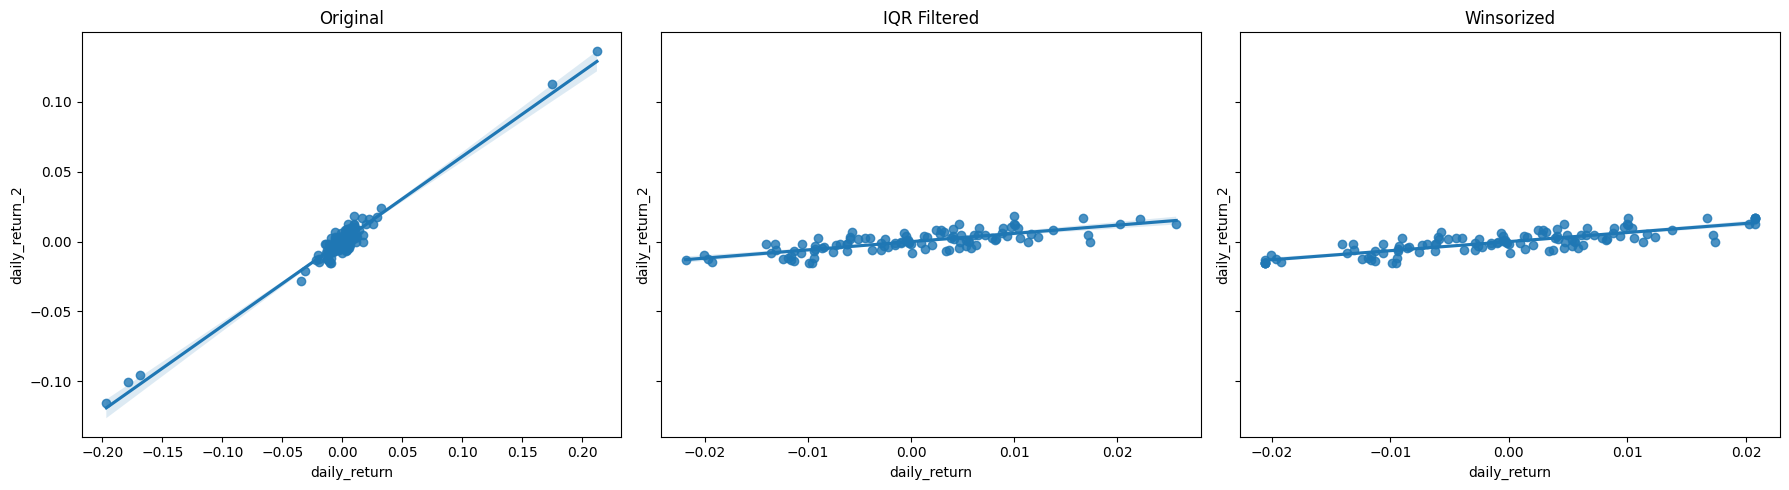

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot original
sns.regplot(df, x="daily_return", y="daily_return_2", ax=axes[0])
axes[0].set_title("Original")

# Plot IQR-filtered
sns.regplot(df_iqr_filtered, x="daily_return", y="daily_return_2", ax=axes[1])
axes[1].set_title("IQR Filtered")

# Plot winsorized
sns.regplot(
    pd.DataFrame({
        'daily_return': winsorized_daily_return,
        'daily_return_2': winsorized_daily_return_2
    }),
    x="daily_return", y="daily_return_2", ax=axes[2]
)
axes[2].set_title("Winsorized")

plt.tight_layout()
plt.show()
